In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

#metrics
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc


%matplotlib inline

In [2]:
#df_math = pd.read_csv('student-mat.csv')
#df_port = pd.read_csv('student-por.csv')

### Importing SQL Table from AWS

In [7]:
cnx = create_engine('postgresql://nataliabernardo@34.205.20.13:5432/postgres')
df_port = pd.read_sql_query('''SELECT * FROM students''',cnx)
df_port.head()

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,...,famrel,freetime,goout,dalc,walc,health,absences,g1,g2,g3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [6]:
cat_data = pd.get_dummies(df_port[['school', 'sex','address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']],drop_first=True)
nominal_cat = pd.get_dummies(df_port[['Mjob','Fjob','reason','guardian']],drop_first=True)
numeric_data = df_port[['age','Medu','Fedu','traveltime','studytime','famrel','freetime','goout','Dalc','Walc','health','absences','failures']]

In [7]:
grades = pd.DataFrame()
#pass = 0, fail = 1
def passfail(grade):
    if grade >=10:
        return 0
    if grade <10:
        return 1
grades['G1'] = df_port['G1'].apply(passfail)
grades['G2'] = df_port['G2'].apply(passfail)
grades['G3'] = df_port['G3'].apply(passfail)

In [8]:
df = pd.concat([grades, cat_data,numeric_data, nominal_cat], axis = 1)

In [9]:
df.to_csv('df_students.csv', encoding='utf-8', index=False)

In [10]:
df.columns

Index(['G1', 'G2', 'G3', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3',
       'Pstatus_T', 'schoolsup_yes', 'famsup_yes', 'paid_yes',
       'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes',
       'romantic_yes', 'age', 'Medu', 'Fedu', 'traveltime', 'studytime',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
       'failures', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_health', 'Fjob_other', 'Fjob_services',
       'Fjob_teacher', 'reason_home', 'reason_other', 'reason_reputation',
       'guardian_mother', 'guardian_other'],
      dtype='object')

## Train/Test Split

In [11]:
X = df.drop(['G1','G2','G3'], axis = 1)
y = df['G3']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
import statsmodels.api as sm
x = sm.add_constant(X_train, prepend = False)
model = sm.GLM(y_train, X_train)
model = model.fit()
model.summary()

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     G3   No. Observations:                  434
Model:                            GLM   Df Residuals:                      395
Model Family:                Gaussian   Df Model:                           38
Link Function:               identity   Scale:                  0.106033864431
Method:                          IRLS   Log-Likelihood:                -108.44
Date:                Mon, 19 Feb 2018   Deviance:                       41.883
Time:                        11:09:25   Pearson chi2:                     41.9
No. Iterations:                     2                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
school_MS             0.2144      0.040      5.356      0.000       0.136       0.293
sex_M                 0.0361      0.038      0.953      0.340      -0.038       0.110
address_U            -0.0239      0.039     -0.609      0.543      -0.101       0.053
famsize_LE3          -0.0516      0.037     -1.387      0.165      -0.125       0.021
Pstatus_T             0.0064      0.053      0.120      0.905      -0.098       0.111
schoolsup_yes         0.0600      0.053      1.122      0.262      -0.045       0.165
famsup_yes            0.0126      0.034      0.368      0.713      -0.054       0.080
paid_yes              0.0214      0.070      0.304      0.761      -0.117       0.159
activities_yes       -0.0162      0.033     -0.486      0.627      -0.082       0.049
nursery_yes           0.0392      0.041      0.967      0.333      -0.040       0.119
higher_yes           -0.1770      0.055     -3.238      0.001      -0.284      -0.070
internet_yes         -0.0067      0.041     -0.164      0.870      -0.087       0.074
romantic_yes          0.0261      0.035      0.748      0.454      -0.042       0.095
age                  -0.0024      0.009     -0.283      0.777      -0.019       0.014
Medu                  0.0214      0.023      0.916      0.360      -0.024       0.067
Fedu                 -0.0221      0.022     -1.018      0.309      -0.065       0.020
traveltime           -0.0182      0.023     -0.785      0.432      -0.064       0.027
studytime            -0.0068      0.021     -0.325      0.745      -0.048       0.034
famrel               -0.0175      0.017     -1.001      0.317      -0.052       0.017
freetime              0.0260      0.016      1.593      0.111      -0.006       0.058
goout                 0.0006      0.016      0.035      0.972      -0.031       0.032
Dalc                  0.0114      0.022      0.517      0.605      -0.032       0.055
Walc                  0.0042      0.018      0.236      0.813      -0.030       0.039
health               -0.0008      0.012     -0.072      0.942      -0.024       0.022
absences              0.0066      0.004      1.737      0.082      -0.001       0.014
failures              0.1772      0.031      5.792      0.000       0.117       0.237
Mjob_health           0.0074      0.081      0.091      0.927      -0.151       0.165
Mjob_other            0.0149      0.045      0.333      0.739      -0.073       0.103
Mjob_services         0.0072      0.057      0.128      0.898      -0.104       0.118
Mjob_teacher         -0.0687      0.078     -0.882      0.378      -0.221       0.084
Fjob_health           0.2529      0.120      2.115      0.034       0.019       0.487
Fjob_other            0.1178      0.067      1.764      0.078      -0.013       0.249
Fjob_services         0.1577      0.070      2.238      0.025       0.020       0.296
Fjob_teacher          0.1876      0.112      1.671      0.095     

#### with normalization

In [14]:
normalizer = preprocessing.Normalizer()
X_norm = normalizer.fit_transform(X)

In [15]:
X_train_norm, X_test_norm, y_train, y_test = train_test_split(X_norm, y, test_size=0.33, random_state=42)

## Models Comparison

In [16]:
models = [LogisticRegression(),
          GaussianNB(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          GradientBoostingClassifier(),
          XGBClassifier()]

models_norm = [KNeighborsClassifier(), 
          SVC(probability=True)]

model_names = ['Logistic', 'Naive Bayes','Decision Tree', 'Random Forest','Gradient Boosting','KNN', 'SVM','XGBoost']

In [17]:
accuracy = []
precision_pass = []
precision_fail = []
recall_pass = []
recall_fail = []
f1_pass = []
f1_fail = []
auc = []

## Go through the models and find the scores
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    accuracy.append( accuracy_score(y_test, y_pred) )
    precision_pass.append( precision_score(y_test, y_pred, pos_label=0) )
    precision_fail.append( precision_score(y_test, y_pred, pos_label=1) )
    recall_pass.append( recall_score(y_test, y_pred, pos_label=0))
    recall_fail.append( recall_score(y_test, y_pred, pos_label=1))
    f1_pass.append( f1_score(y_test, y_pred, pos_label=0) )
    f1_fail.append( f1_score(y_test, y_pred, pos_label=1) )
    auc.append(roc_auc_score(y_test, y_pred_prob))
    
for model in models_norm:
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    
    accuracy.append( accuracy_score(y_test, y_pred) )
    precision_pass.append( precision_score(y_test, y_pred, pos_label=0) )
    precision_fail.append( precision_score(y_test, y_pred, pos_label=1) )
    recall_pass.append( recall_score(y_test, y_pred, pos_label=0))
    recall_fail.append( recall_score(y_test, y_pred, pos_label=1))
    f1_pass.append( f1_score(y_test, y_pred, pos_label=0) )
    f1_fail.append( f1_score(y_test, y_pred, pos_label=1) )
    auc.append(roc_auc_score(y_test, y_pred_prob))

accuracy_df = pd.DataFrame({'accuracy':accuracy, 'precision-pass':precision_pass, 'precision-fail':precision_fail,
                            'recall-pass':recall_pass, 'recall-fail':recall_fail, 'f1-pass':f1_pass, 'f1-fail':f1_fail, 'auc': auc})
accuracy_df.set_index([model_names])

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,accuracy,auc,f1-fail,f1-pass,precision-fail,precision-pass,recall-fail,recall-pass
Logistic,0.874419,0.826776,0.425532,0.929504,0.526316,0.908163,0.357143,0.951872
Naive Bayes,0.837209,0.792208,0.520548,0.901961,0.422222,0.947059,0.678571,0.860963
Decision Tree,0.818605,0.607238,0.315789,0.895442,0.310345,0.897849,0.321429,0.893048
Random Forest,0.869767,0.737586,0.176471,0.929293,0.500000,0.880383,0.107143,0.983957
Gradient Boosting,0.869767,0.823147,0.391304,0.927083,0.500000,0.903553,0.321429,0.951872
KNN,0.883721,0.801375,0.468085,0.934726,0.578947,0.913265,0.392857,0.957219
SVM,0.851163,0.801375,0.058824,0.919192,0.166667,0.870813,0.035714,0.973262
XGBoost,0.869767,0.801375,0.000000,0.930348,0.000000,0.869767,0.000000,1.000000


### ROC Curve

In [20]:
## Calc and store each ROC and AUC
fpr_list = []
tpr_list = []
auc_list = []
for model in models:
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(metrics.auc(fpr, tpr))
    
for model in models_norm:
    y_pred_prob = model.predict_proba(X_test_norm)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(metrics.auc(fpr, tpr))

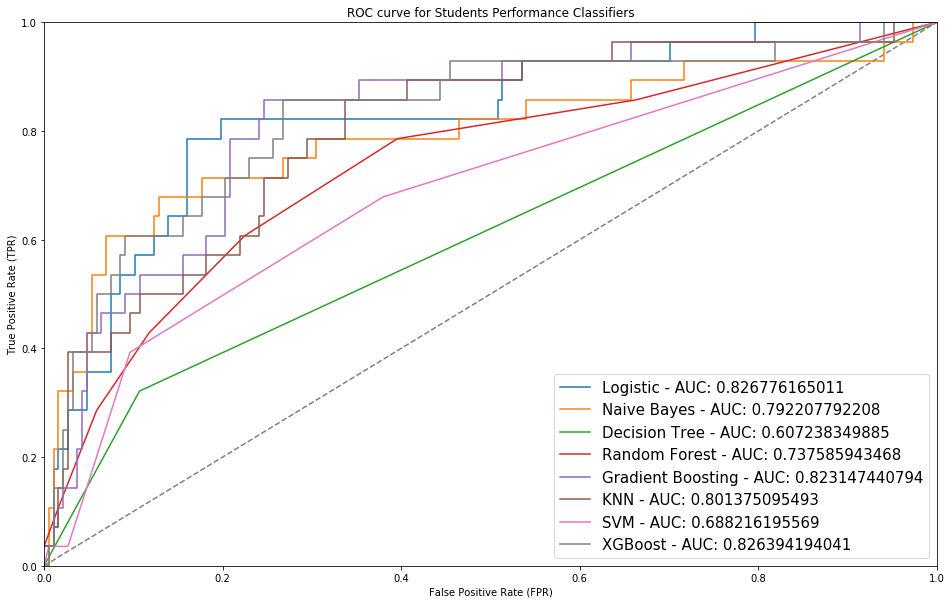

In [21]:
## Plot them all on 1 graph
plt.figure(figsize=(16,10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC curve for Students Performance Classifiers')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], label = model_names[i] + ' - AUC: ' + str(auc_list[i]))
plt.legend(loc = 0, fontsize = 15)